In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.example_libraries import stax, optimizers
import matplotlib.pyplot as plt
import pinns 
import datetime
import jax.scipy.optimize
import jax.flatten_util
import scipy
import scipy.optimize
import tikzplotlib

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
rnd_key = jax.random.PRNGKey(1234)
np.random.seed(1234)

In [3]:

def create_geometry(key, scale = 1):
    scale = scale
    Nt = 24                                                                
    lz = 40e-3                                                             
    Do = 72e-3                                                            
    Di = 51e-3                                                            
    hi = 13e-3                                                             
    bli = 3e-3                                                             
    Dc = 3.27640e-2                                                           
    hc = 7.55176e-3                                                           
    ri = 20e-3                                                           
    ra = 18e-3                                                           
    blc = hi-hc                                                           
    rm = (Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri)                 
    R = rm-ri
    O = np.array([rm/np.sqrt(2),rm/np.sqrt(2)])
    alpha1 = -np.pi*3/4       
    alpha2 = np.math.asin((hc-rm/np.sqrt(2))/R)
    alpha = np.abs(alpha2-alpha1)
    
    A = np.array([[O[0] - ri/np.sqrt(2), O[1] - ri/np.sqrt(2)], [O[0] - Dc, O[1] - hc]])
    b = np.array([[A[0,0]*ri/np.sqrt(2)+A[0,1]*ri/np.sqrt(2)],[A[1,0]*Dc+A[1,1]*hc]])
    C = np.linalg.solve(A,b)
    
    knots1 = np.array([[Do,Do * np.tan(np.pi/8)],[Do/np.sqrt(2),Do/np.sqrt(2)],[rm/np.sqrt(2),rm/np.sqrt(2)],[ri/np.sqrt(2),ri/np.sqrt(2)]])
    #knots2 = np.array([[Dc,hc],[Dc+blc,hi],[Di-bli,hi],[Di,hi-bli],[Di,0]])
    knots2 = np.array([[Di,hi-bli],[Di-bli,hi],[Dc+blc,hi],[Dc,hc]])
    knots3 = (knots1+knots2)/2
    knots3[-1,:] = C.flatten()
    knots = np.concatenate((knots1[None,...],knots3[None,...],knots2[None,...]),0)
    weights = np.ones(knots.shape[:2])
    weights[1,-1] = np.sin((np.pi-alpha)/2)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,-0.33,0.33,1]),1)
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)

    geom1 = pinns.geometry.PatchNURBSParam([basis1, basis2], knots, weights, 0, 2, key)
   
    knots2 = np.array([ [ [Dc,0],[Dc+blc,0],[Di-bli,0],[Di,0] ] , [[Dc,hc],[Dc+blc,hi],[Di-bli,hi],[Di,hi-bli]] ]) 
    knots2 = knots2[:,::-1,:]
    weights = np.ones(knots2.shape[:2])
    
    basis1 = pinns.bspline.BSplineBasisJAX(np.linspace(-1,1,2),1)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,-0.33,0.33,1]),1)

    geom2 = pinns.geometry.PatchNURBSParam([basis1, basis2], knots2, weights, 0, 2, key)
   
    knots = np.array([ [ [0,0] , [Dc/2,0] , [Dc,0] ] , [ [ri/np.sqrt(2),ri/np.sqrt(2)] , [C[0,0],C[1,0]] , [Dc,hc] ]])
    
    basis1 = pinns.bspline.BSplineBasisJAX(np.linspace(-1,1,2),1)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)
    
    weights = np.ones(knots.shape[:2])
    weights[1,1] = np.sin((np.pi-alpha)/2)
    geom3 = pinns.geometry.PatchNURBSParam([basis1, basis2], knots, weights, 0, 2, key)

    knots1 = np.array([[Do,0],[Do,Do * np.tan(np.pi/8)]])
    knots2 = np.array([[Di,0],[Di,hi-bli]])
    knots3 = (knots1+knots2)/2
    knots = np.concatenate((knots1[None,...],knots3[None,...],knots2[None,...]),0)
    weights = np.ones(knots.shape[:2])

    basis2 = pinns.bspline.BSplineBasisJAX(np.linspace(-1,1,2),1)
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)

    geom4 = pinns.geometry.PatchNURBSParam([basis1, basis2], knots, weights, 0, 2, key)
    return  geom1, geom3, geom2, geom4

In [4]:
geom1, geom2, geom3, geom4 = create_geometry(rnd_key)

In [5]:
def interface_function2d(nd, endpositive, endzero, nn):

    faux = lambda x: ((x-endzero)**2/(endpositive-endzero)**2)
    if nd == 0:
        fret = lambda ws, x: (nn(ws, x[...,1][...,None]).flatten()*faux(x[...,0]))[...,None]
    else:
        fret = lambda ws, x: (nn(ws, x[...,0][...,None]).flatten()*faux(x[...,1]))[...,None]
    return fret

def jump_function2d(nd, pos_y, nn):

    faux = lambda x: jnp.exp(-2.0*jnp.abs(x-pos_y))
    if nd == 1:
        fret = lambda ws, x: (nn(ws, x[...,1][...,None]).flatten()*faux(x[...,0]))[...,None]
    else:
        fret = lambda ws, x: (nn(ws, x[...,0][...,None]).flatten()*faux(x[...,1]))[...,None]
    return fret

def ExpHat(x, scale = 0.5):
    return jnp.exp(-jnp.abs(x)/scale)

def interface_function1d(dembedding: int, dim: int, zeros: list[int], ones: list[int], nn: callable, alpha: float = 2.0) -> callable:

    faux = lambda y,one,zero: ((y-zero)**alpha/(one-zero)**alpha)

    if dembedding==3:
        dims = list(set(range(dembedding)) - {dim})
        fret = lambda ws, x, *params: (nn(ws, x[...,dim][...,None], *params)*faux(x[...,dims[0]],ones[0],zeros[0])[...,None]*faux(x[...,dims[1]],ones[1],zeros[1])[...,None])
    elif dembedding==2:
        dims = list(set(range(dembedding)) - {dim})
        fret = lambda ws, x, *params: (nn(ws, x[...,dim][...,None], *params)*faux(x[...,dims[0]],ones[0],zeros[0])[...,None])

    return fret

def fix_variables(dims:int , variables_keep: np.ndarray, values_fix: np.ndarray, nn: callable) -> callable:
    mult = jnp.array(variables_keep)
    add = jnp.array(values_fix) 
    
    fret = lambda ws, x, *params:  nn(ws,x*mult+add,*params)
    
    return fret 

class Model(pinns.PINN):
    def __init__(self, rand_key):
        super().__init__()
        self.key = rand_key

        N = [32,32]
        nl = 10
        acti = stax.Tanh
        acti =  stax.elementwise(lambda x: jax.nn.leaky_relu(x)**2)

        
        w_init = jax.nn.initializers.normal(0.1)
        block_first = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl, W_init=w_init, b_init=jax.nn.initializers.zeros), acti, stax.Dense(nl, W_init=w_init, b_init=jax.nn.initializers.zeros), acti),stax.Dense(nl, W_init=w_init, b_init=jax.nn.initializers.zeros)),stax.FanInSum)
        block = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl, W_init=w_init, b_init=jax.nn.initializers.zeros), acti, stax.Dense(nl, W_init=w_init, b_init=jax.nn.initializers.zeros), acti),stax.Dense(nl, W_init=w_init, b_init=jax.nn.initializers.zeros)),stax.FanInSum)
        
        #block_first = stax.serial(stax.Dense(nl, W_init=w_init, b_init=jax.nn.initializers.zeros), acti)
        #block = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl, W_init=w_init, b_init=jax.nn.initializers.zeros), acti, stax.Dense(nl, W_init=w_init, b_init=jax.nn.initializers.zeros), acti),stax.Identity),stax.FanInSum)

        self.add_neural_network('u1',stax.serial(block_first,block,block, block, block, stax.Dense(1)),(-1,2)) # iron
        self.add_neural_network('u4',stax.serial(block_first,block,block, block, block, stax.Dense(1)),(-1,2)) # iron 2
        self.add_neural_network('u2',stax.serial(block_first,block,block, block, block, stax.Dense(1)),(-1,2)) # air 
        self.add_neural_network('u3',stax.serial(block_first,block,block, block, block, stax.Dense(1)),(-1,2)) # copper
        self.add_neural_network('u1_0.3',stax.serial(block_first, block, block, block, stax.Dense(1)),(-1,1))
        self.add_neural_network('u1_0.7',stax.serial(block_first, block, block, block, stax.Dense(1)),(-1,1))
       
        self.jump1 = jump_function2d(0, -0.33, self.neural_networks['u1_0.3'])
        self.jump2 = jump_function2d(0,  0.33, self.neural_networks['u1_0.7'])
        
        
        self.nns1 = lambda  ws, x:  self.neural_networks['u1'](ws['u1'],x) + self.jump1(ws['u1_0.3'], x) + self.jump2(ws['u1_0.7'], x)
        self.nns2 = lambda  ws, x:  self.neural_networks['u2'](ws['u2'], x)
        self.nns3 = lambda  ws, x:  self.neural_networks['u3'](ws['u3'], x)
        self.nns4 = lambda  ws, x:  self.neural_networks['u4'](ws['u4'], x)

        
        
        self.interface12 = interface_function1d(2, 1, [-1], [1], fix_variables(2, np.array([1,0]), np.array([0,1]), self.nns1))
        self.interface21 = interface_function1d(2, 0, [-1], [1], fix_variables(2, np.array([0,1]), np.array([1,0]), self.nns2))
        self.interface23 = interface_function1d(2, 0, [-1], [1], fix_variables(2, np.array([1,0]), np.array([0,1]), self.nns2)) 
        self.interface32 = interface_function1d(2, 0, [-1], [1], fix_variables(2, np.array([1,0]), np.array([0,1]), self.nns3))
        self.interface13 = interface_function1d(2, 1, [-1], [1], fix_variables(2, np.array([0,1]), np.array([1,0]), self.nns1))
        self.interface31 = interface_function1d(2, 1, [-1], [1], fix_variables(2, np.array([0,1]), np.array([1,0]), self.nns3))
        self.interface14 = interface_function1d(2, 0, [-1], [1], fix_variables(2, np.array([1,0]), np.array([0,-1]), self.nns1))
        self.interface41 = interface_function1d(2, 0, [1], [-1], fix_variables(2, np.array([1,0]), np.array([0,1]), self.nns4))
        self.interface34 = interface_function1d(2, 1, [-1], [1], fix_variables(2, np.array([1,0]), np.array([0,-1]), self.nns3))
        self.interface43 = interface_function1d(2, 0, [1], [-1], fix_variables(2, np.array([0,1]), np.array([1,0]), self.nns4))

        

        self.scale_H = 1000
        self.scale_A = 70
        
        # self.mu0 = 0.001
        # self.mur = 2000
        # self.J0 =  1250000

        # self.k1 = 0.001
        # self.k2 = 1.65/5000
        # self.k3 = 0.5

        self.mu0 = np.pi*4*1e-7
        self.mur = 2000
        self.J0 = 15*1e6
        
        self.k1 = 1
        self.k2 = 1.65
        self.k3 = 500
        
        self.points = self.get_points_MC(100000, self.key)
    

    def get_points_MC(self, N, key):        

        points = {}


        ys = jax.random.uniform(key ,(N,2))*2-1
        Weights = jnp.ones((N,))*4/ys.shape[0]
        # ys = np.array(jax.random.uniform(self.key, (N,2)))*2-1
        # Weights = jnp.ones((N,))*4/ys.shape[0]


        points['ys1'] = ys
        points['ws1'] = Weights
        points['omega1'], points['G1'], points['K1'] = geom1.GetMetricTensors(ys)
       
        points['ys2'] = ys
        points['ws2'] = Weights
        points['omega2'], points['G2'], points['K2'] = geom2.GetMetricTensors(ys)
        
        points['ys3'] = ys
        points['ws3'] = Weights
        points['omega3'], points['G3'], points['K3'] = geom3.GetMetricTensors(ys)
       
        points['ys4'] = ys
        points['ws4'] = Weights
        points['omega4'], points['G4'], points['K4'] = geom4.GetMetricTensors(ys)

        return points


    def solution1(self, ws, x):
        # iron
        alpha = 2
        bcs_mult = (1+x[...,0])[...,None]/2
        u = self.nns1(ws, x)
        ints = self.interface21(ws, x) + self.interface31(ws, x) + self.interface41(ws, x)         
        return (u+ints)*bcs_mult


    def solution2(self, ws, x):
        alpha = 2
        bcs_mult = (1+x[...,1])[...,None]/2
        u = self.nns2(ws, x)
        ints = self.interface12(ws, x) + self.interface32(ws, x)
        return (u+ints)*bcs_mult
    
    def solution3(self, ws, x):
        alpha = 2
        u = self.nns3(ws, x)
        ints = self.interface13(ws, x)+self.interface23(ws,x)+self.interface43(ws,x)
        return (u+ints)
        
    def solution4(self, ws, x):
        alpha = 2
        bcs_mult = (1+x[...,0])[...,None]/2
        u = self.nns4(ws, x)
        ints = self.interface14(ws,x)+self.interface34(ws,x)
        return (u+ints)*bcs_mult

    def nu_model(self, grad_a):
        b2 = grad_a[...,0]**2+grad_a[...,1]**2
        return self.k1*jnp.exp(self.k2*b2)+self.k3
    def nu_model(self, b2):
       
        return self.k1/self.scale_H*jnp.exp(self.k2*b2/self.scale_A**2)+self.k3/self.scale_H
    
    def loss_pde(self, ws, points):
        grad1 = pinns.operators.gradient(lambda x : self.solution1(ws,x))(points['ys1'])[...,0,:]
        grad2 = pinns.operators.gradient(lambda x : self.solution2(ws,x))(points['ys2'])[...,0,:]
        grad3 = pinns.operators.gradient(lambda x : self.solution3(ws,x))(points['ys3'])[...,0,:]
        grad4 = pinns.operators.gradient(lambda x : self.solution4(ws,x))(points['ys4'])[...,0,:]
        
        grad1x = jnp.einsum('mij,mi->mj',points['G1'],grad1)
        grad4x = jnp.einsum('mij,mi->mj',points['G4'],grad4)
        
        bi1 = jnp.einsum('mi,mij,mj->m',grad1,points['K1'],grad1)
        bi4 = jnp.einsum('mi,mij,mj->m',grad4,points['K4'],grad4)

        # bi1 = jnp.einsum('mi,mi->m',grad1x,grad1x)
        # bi4 = jnp.einsum('mi,mi->m',grad4x,grad4x)
        # bi1 = jnp.einsum('mi,mij,mjk,mk->m',grad1,points['G1'],jnp.transpose(points['G1'],[0,2,1]),grad1)
        # bi4 = jnp.einsum('mi,mij,mjk,mk->m',grad4,points['G4'],jnp.transpose(points['G4'],[0,2,1]),grad4)
        
        lpde1 = 0.5*(self.scale_H*self.mu0)*jnp.dot(self.nu_model(bi1)*jnp.einsum('mi,mij,mj->m',grad1,points['K1'],grad1), points['ws1']) 
        lpde2 = 0.5*jnp.dot(jnp.einsum('mi,mij,mj->m',grad2,points['K2'],grad2), points['ws2'])  
        lpde3 = 0.5*jnp.dot(jnp.einsum('mi,mij,mj->m',grad3,points['K3'],grad3), points['ws3'])  - self.scale_H*self.mu0*jnp.dot(self.J0/(self.scale_H/self.scale_A)*self.solution3(ws,points['ys3']).flatten()*points['omega3']  ,points['ws3'])
        lpde4 = 0.5*(self.scale_H*self.mu0)*jnp.dot(self.nu_model(bi4)*jnp.einsum('mi,mij,mj->m',grad4,points['K4'],grad4), points['ws4'])
        return lpde1+lpde2+lpde3+lpde4

    def loss(self, ws, pts):
        lpde = self.loss_pde(ws, pts)
        return lpde
    

[DeviceArray(-0.00086971, dtype=float64), DeviceArray(-0.00081838, dtype=float64), DeviceArray(-0.00086971, dtype=float64), DeviceArray(-0.00086971, dtype=float64)]
[DeviceArray(-0., dtype=float64), DeviceArray(-0., dtype=float64), DeviceArray(-0.00041274, dtype=float64), DeviceArray(-0., dtype=float64)]


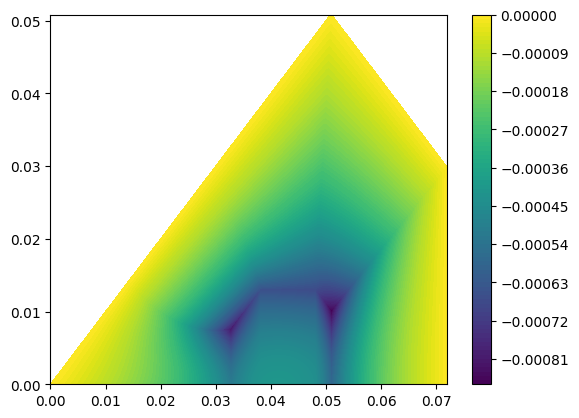

In [6]:
rnd_key = jax.random.PRNGKey(1235)
model = Model(rnd_key)
w0 = model.init_unravel()
weights = model.weights 

x,y = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))
ys = np.concatenate((x.flatten()[:,None],y.flatten()[:,None]),1)
xy1 = geom1(ys)
xy2 = geom2(ys)
xy3 = geom3(ys)
xy4 = geom4(ys)

u1 = model.solution1(weights, ys).reshape(x.shape) / model.scale_A
u2 = model.solution2(weights, ys).reshape(x.shape) / model.scale_A
u3 = model.solution3(weights, ys).reshape(x.shape) / model.scale_A
u4 = model.solution4(weights, ys).reshape(x.shape) / model.scale_A

plt.figure()
plt.contourf(xy1[:,0].reshape(x.shape), xy1[:,1].reshape(x.shape), u1, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.contourf(xy2[:,0].reshape(x.shape), xy2[:,1].reshape(x.shape), u2, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.contourf(xy3[:,0].reshape(x.shape), xy3[:,1].reshape(x.shape), u3, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.contourf(xy4[:,0].reshape(x.shape), xy4[:,1].reshape(x.shape), u4, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.colorbar()

print(([u1.min(),u2.min(),u3.min(),u4.min()]))
print(([u1.max(),u2.max(),u3.max(),u4.max()]))


In [7]:
rnd_key = jax.random.PRNGKey(1235)
model = Model(rnd_key)
w0 = model.init_unravel()
weights = model.weights 

dev = jax.devices()[1]


batch_size = 5000

lr_opti = optimizers.piecewise_constant([2000,4000,6000,8000,10000], [0.001*2, 0.001/2, 0.001/4, 0.001/8,0.001/16,0.001/32])
opt_init, opt_update, get_params = optimizers.adam(lr_opti)
# opt_init, opt_update, get_params = optimizers.adam(step_size=0.001)

opt_state = opt_init(weights)

# get initial parameters
params = get_params(opt_state)

loss_grad = jax.jit(lambda ws, pts: (model.loss(ws, pts), jax.grad(model.loss)(ws, pts)), device = dev)

def step(params, opt_state, key):
    # points = model.get_points_MC(5000)
    points = model.get_points_MC(batch_size, key)
    loss, grads = loss_grad(params, points)
    opt_state = opt_update(0, grads, opt_state)

    params = get_params(opt_state)
    
    return params, opt_state, loss

step_compiled = jax.jit(step, device = dev)
step_compiled(params, opt_state, rnd_key)

n_epochs = 12000

weights_intermediate = dict()
history_loss = np.zeros((n_epochs,))
tme = datetime.datetime.now()
for k in range(n_epochs):    
    params, opt_state, loss = step_compiled(params, opt_state, jax.random.PRNGKey(np.random.randint(1000)))
    history_loss[k] = loss
    if k%500==0:
        weights_intermediate[k] = params.copy()
    print('Epoch %d/%d - loss value %e'%(k+1, n_epochs, loss))
    
# update params
model.weights = params
weights = params
tme = datetime.datetime.now() - tme
print('Elapsed time ', tme)
    

Epoch 1/12000 - loss value 1.225366e-02
Epoch 2/12000 - loss value 4.689244e-03
Epoch 3/12000 - loss value -3.328137e-03
Epoch 4/12000 - loss value -9.810645e-03
Epoch 5/12000 - loss value -1.609115e-02
Epoch 6/12000 - loss value -2.304285e-02
Epoch 7/12000 - loss value -2.994529e-02
Epoch 8/12000 - loss value -3.718424e-02
Epoch 9/12000 - loss value -4.151807e-02
Epoch 10/12000 - loss value -4.502163e-02
Epoch 11/12000 - loss value -5.017928e-02
Epoch 12/12000 - loss value -5.614513e-02
Epoch 13/12000 - loss value -6.141188e-02
Epoch 14/12000 - loss value -6.655193e-02
Epoch 15/12000 - loss value -7.145135e-02
Epoch 16/12000 - loss value -7.200807e-02
Epoch 17/12000 - loss value -7.293116e-02
Epoch 18/12000 - loss value -7.121029e-02
Epoch 19/12000 - loss value -7.273514e-02
Epoch 20/12000 - loss value -7.751878e-02
Epoch 21/12000 - loss value -7.806360e-02
Epoch 22/12000 - loss value -8.088010e-02
Epoch 23/12000 - loss value -8.383107e-02
Epoch 24/12000 - loss value -8.099249e-02
Epo

In [ ]:
plt.figure()
plt.plot(np.arange(n_epochs)+1, history_loss)
plt.xlabel('epochs')
plt.ylabel('loss')


In [ ]:
x,y = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))
ys = np.concatenate((x.flatten()[:,None],y.flatten()[:,None]),1)
xy1 = geom1(ys)
xy2 = geom2(ys)
xy3 = geom3(ys)
xy4 = geom4(ys)

u1 = model.solution1(weights, ys).reshape(x.shape) / model.scale_A
u2 = model.solution2(weights, ys).reshape(x.shape) / model.scale_A
u3 = model.solution3(weights, ys).reshape(x.shape) / model.scale_A
u4 = model.solution4(weights, ys).reshape(x.shape) / model.scale_A

plt.figure()
ax = plt.gca()
plt.contourf(xy1[:,0].reshape(x.shape), xy1[:,1].reshape(x.shape), u1, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.contourf(xy2[:,0].reshape(x.shape), xy2[:,1].reshape(x.shape), u2, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.contourf(xy3[:,0].reshape(x.shape), xy3[:,1].reshape(x.shape), u3, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.contourf(xy4[:,0].reshape(x.shape), xy4[:,1].reshape(x.shape), u4, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.colorbar()
plt.xlabel(r'$x_1$ [m]')
plt.ylabel(r'$x_2$ [m]')
plt.savefig('quad_nonlin_solution.pdf')
yspace = np.linspace(-1,1,100)[:,None]
YS  = [np.concatenate((yspace,yspace*0-1),-1)]
YS += [np.concatenate((yspace,yspace*0+1),-1)]
YS += [np.concatenate((yspace*0-1,yspace),-1)]
YS += [np.concatenate((yspace*0+1,yspace),-1)]
geoms = [geom1, geom2, geom3, geom4]

plt.figure()
for i in range(4): 
    for k in range(4):
        xs = geoms[i](YS[k])
        plt.plot(xs[:,0], xs[:,1], 'k')
plt.xlabel(r'$x_1$ [m]')
plt.ylabel(r'$x_2$ [m]')
plt.text(0.04,0.025,r'$\Omega_1$')
plt.text(0.015,0.005,r'$\Omega_2$')
plt.text(0.04,0.005,r'$\Omega_3$')
plt.text(0.06,0.005,r'$\Omega_4$')
tikzplotlib.save('quad_subdomains.tex')


In [ ]:
try:
    from quad_2d_fem import FEM
    fem = FEM(mu0=model.mu0,mur=model.mur,J0 = model.J0, meshsize = 0.001/2, k1 = model.k1, k2 = model.k2, k3 = model.k3, nonlin=True)

    u1_ref = fem(np.array(xy1)).reshape(x.shape)
    u2_ref = fem(np.array(xy2)).reshape(x.shape)
    u3_ref = fem(np.array(xy3)).reshape(x.shape)
    u4_ref = fem(np.array(xy4)).reshape(x.shape)

    u1 = model.solution1(weights, ys).reshape(x.shape) / model.scale_A
    u2 = model.solution2(weights, ys).reshape(x.shape) / model.scale_A
    u3 = model.solution3(weights, ys).reshape(x.shape) / model.scale_A
    u4 = model.solution4(weights, ys).reshape(x.shape) / model.scale_A

    plt.figure()
    ax = plt.gca()
    plt.contourf(xy1[:,0].reshape(x.shape), xy1[:,1].reshape(x.shape), u1_ref, levels = 100, vmin = min([u1_ref.min(),u2_ref.min(),u3_ref.min(),u4_ref.min()]), vmax = max([u1_ref.max(),u2_ref.max(),u3_ref.max(),u4_ref.max()]))
    plt.contourf(xy2[:,0].reshape(x.shape), xy2[:,1].reshape(x.shape), u2_ref, levels = 100, vmin = min([u1_ref.min(),u2_ref.min(),u3_ref.min(),u4_ref.min()]), vmax = max([u1_ref.max(),u2_ref.max(),u3_ref.max(),u4_ref.max()]))
    plt.contourf(xy3[:,0].reshape(x.shape), xy3[:,1].reshape(x.shape), u3_ref, levels = 100, vmin = min([u1_ref.min(),u2_ref.min(),u3_ref.min(),u4_ref.min()]), vmax = max([u1_ref.max(),u2_ref.max(),u3_ref.max(),u4_ref.max()]))
    plt.contourf(xy4[:,0].reshape(x.shape), xy4[:,1].reshape(x.shape), u4_ref, levels = 100, vmin = min([u1_ref.min(),u2_ref.min(),u3_ref.min(),u4_ref.min()]), vmax = max([u1_ref.max(),u2_ref.max(),u3_ref.max(),u4_ref.max()]))
    plt.colorbar()
    plt.xlabel(r'$x_1$ [m]')
    plt.ylabel(r'$x_2$ [m]')

    delta1 = np.abs(u1-u1_ref)
    delta2 = np.abs(u2-u2_ref)
    delta3 = np.abs(u3-u3_ref)
    delta4 = np.abs(u4-u4_ref)

    plt.figure()
    ax = plt.gca()
    plt.contourf(xy2[:,0].reshape(x.shape), xy2[:,1].reshape(x.shape), delta2, levels = 100, vmin = min([delta1.min(),delta2.min(),delta3.min(),delta4.min()]), vmax = max([delta1.max(),delta2.max(),delta3.max(),delta4.max()]))
    plt.contourf(xy3[:,0].reshape(x.shape), xy3[:,1].reshape(x.shape), delta3, levels = 100, vmin = min([delta1.min(),delta2.min(),delta3.min(),delta4.min()]), vmax = max([delta1.max(),delta2.max(),delta3.max(),delta4.max()]))
    plt.contourf(xy4[:,0].reshape(x.shape), xy4[:,1].reshape(x.shape), delta4, levels = 100, vmin = min([delta1.min(),delta2.min(),delta3.min(),delta4.min()]), vmax = max([delta1.max(),delta2.max(),delta3.max(),delta4.max()]))
    plt.contourf(xy1[:,0].reshape(x.shape), xy1[:,1].reshape(x.shape), delta1, levels = 100, vmin = min([delta1.min(),delta2.min(),delta3.min(),delta4.min()]), vmax = max([delta1.max(),delta2.max(),delta3.max(),delta4.max()]))
    plt.colorbar()
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.savefig('quad_error.pdf')
    #print()
    #print('Linf relative error',max([np.max(delta1),np.max(delta2),np.max(delta3),np.max(delta4)])/max([np.max(u1),np.max(u2),np.max(u3),np.max(u4)])*100, '%')
    
    xs = jnp.concatenate((geom1(model.points['ys1']), geom2(model.points['ys2']), geom3(model.points['ys3']), geom4(model.points['ys4'])),0)

    us_ref = fem(np.array(xs)).flatten()

    us = np.concatenate((model.solution1(weights, model.points['ys1']).flatten(), model.solution2(weights, model.points['ys2']).flatten(), model.solution3(weights, model.points['ys3']).flatten(), model.solution4(weights, model.points['ys4']).flatten())) / model.scale_A
    ws = np.concatenate((model.points['ws1'], model.points['ws2'], model.points['ws3'], model.points['ws4']))
    omegas = np.concatenate((model.points['omega1'], model.points['omega2'], model.points['omega3'], model.points['omega4']))

    errL2 = jnp.dot((us-us_ref)**2,omegas*ws) / jnp.dot((us_ref)**2,omegas*ws)
    errInf = np.max(np.abs(us-us_ref))/np.amax(us_ref)

    print('L2 relative error   %e\nLinf relative error %f %%\nDofs %d\nDofs ANN %d'%(errL2, errInf*100, fem.az.vector().size(), w0.size))
    
    print()
    print()
    
    for k in weights_intermediate:
        print('Epochs %d'%(k))
        weights = weights_intermediate[k]
        us = np.concatenate((model.solution1(weights, model.points['ys1']).flatten(), model.solution2(weights, model.points['ys2']).flatten(), model.solution3(weights, model.points['ys3']).flatten(), model.solution4(weights, model.points['ys4']).flatten())) / model.scale_A
        
        errL2 = jnp.dot((us-us_ref)**2,omegas*ws) / jnp.dot((us_ref)**2,omegas*ws)
        errInf = np.max(np.abs(us-us_ref))/np.amax(us_ref)
        print('L2 relative error   %e\nLinf relative error %f %%'%(errL2, errInf*100))
        print()
    
except:
    print('FENICS not available')